In [64]:
import pysteps.motion as motion
from pysteps import nowcasts
import os
import xarray as xr
from pysteps.utils import conversion, dimension, transformation
# from helper.pre_process_target_input import normalize_data, inverse_normalize_data
import numpy as np
import matplotlib.pyplot as plt


Use local conda env called 'pysteps'

Implementing STEPS nowcast:
https://pysteps.readthedocs.io/en/stable/auto_examples/plot_steps_nowcast.html

my first nowcast colab:
https://colab.research.google.com/github/pySTEPS/pysteps/blob/master/examples/my_first_nowcast.ipynb#scrollTo=CeCVjlNq3-jd
--> Transforming data from long tail to log-norm using 'dBR' unit is explained! using pysteps.utils.transformation.dB_transform()

In [65]:
folder_path = '/Users/jan/Programming/first_CNN_on_Radolan/dwd_nc/own_test_data' #'/home/jan/Programming/remote/first_CNN_on_radolan_remote/dwd_nc/own_test_data'
file_name_radolan = 'testdata_two_days_2019_01_01-02.zarr'
load_path = os.path.join(folder_path, file_name_radolan)
load_path_dem = '/Users/jan/Programming/geo_data/static/dem_benchmark_dataset_1200_1100.zarr'

print(f'loading from: {load_path}')

loading from: /Users/jan/Programming/first_CNN_on_Radolan/dwd_nc/own_test_data/testdata_two_days_2019_01_01-02.zarr


In [66]:
data = xr.open_dataset(load_path, engine='zarr') # , chunks=None # , chunks=None according to Sebastian more efficient as it avoids dask (default is chunks=1)
# Simply reinstalled environment with numpy pandas xarray zarr jupyter
# Now not the same error as in first_CNN_on_Radolan env for some reason
data = data.squeeze()
# Set all negative values of the data to 0
data_min = data.min(skipna=True, dim=None).RV_recalc.values
if data_min < -0.1:
    raise ValueError(f'The min value of the data is {data_min}, which is below the threshold of -0.1')
data = data.where(data >= 0, 0) 
# The where function keeps values where the condition is True and replaces the rest (where it's False) with the value specified, in this case 0.
print(f'min val in data is {data.min(skipna=True, dim=None).RV_recalc.values}')


data = data['RV_recalc'].values
log_data = np.log1p(data)
log_mean = np.nanmean(log_data)
log_std = np.nanstd(log_data)


min val in data is 0.0


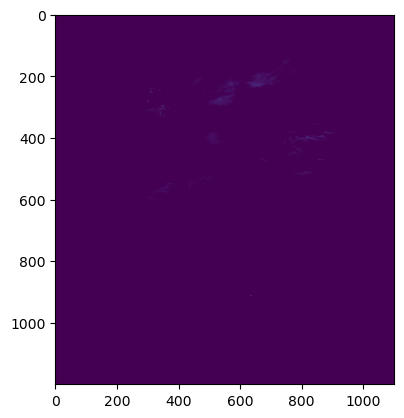

In [67]:
plt.imshow(data[50,:,:])
plt.show()

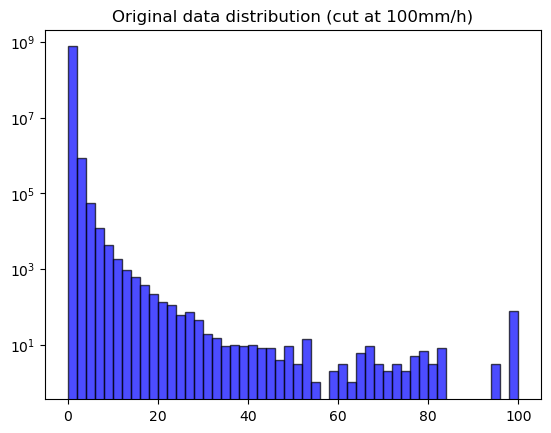

In [68]:
data_plotting = data
data_plotting[data_plotting>100] = 100 #  Cut off all entries that have > 100mm rain
plt.hist(data_plotting.flatten(), bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('Original data distribution (cut at 100mm/h)')
plt.show()

In [69]:
# Threshold and zerovalue is optional
data_db_transformed = transformation.dB_transform(data_plotting, threshold=0.1, zerovalue=-15.0)[0] #This returns a tuple with metatdata, where first entry is actual data
data_db_transformed_flattened = data_db_transformed.flatten()

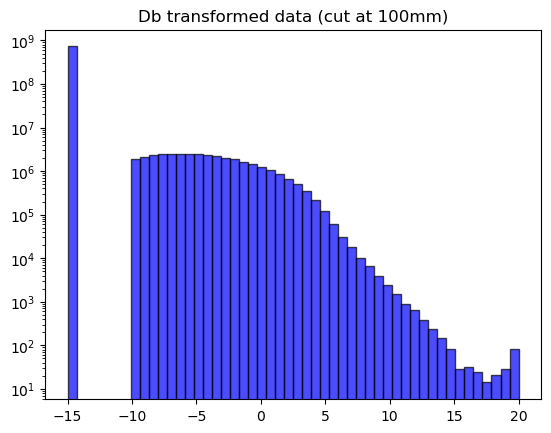

In [70]:
plt.hist(data_db_transformed.flatten(), bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('Db transformed data (cut at 100mm)')
plt.show()

In [ ]:
# Only use the valid data!

valid_precip_dbr = data[~np.isnan(data)].flatten()

plt.figure(figsize=(4, 4), dpi=100)

# Plot the histogram
counts, bins, _ = plt.hist(valid_precip_dbr, bins=40, log=True, edgecolor="black")
plt.autoscale(tight=True, axis="x")
plt.xlabel("Rainfall intensity [dB]")
plt.ylabel("Counts")
plt.title("Precipitation rain rate histogram in dB units")

# Let's add a lognormal distribution that fits that data to the plot.
import scipy

bin_center = (bins[1:] + bins[:-1]) * 0.5
bin_width = np.diff(bins)

# We will only use one composite to fit the function to speed up things.
# First, remove the no precip areas."
precip_to_fit = valid_precip_dbr[valid_precip_dbr > -15]

fit_params = scipy.stats.lognorm.fit(precip_to_fit)

fitted_pdf = scipy.stats.lognorm.pdf(bin_center, *fit_params)

# Multiply pdf by the bin width and the total number of grid points: pdf -> total counts per bin.
fitted_pdf = fitted_pdf * bin_width * precip_to_fit.size

# Plot the log-normal fit
plt.plot(bin_center, fitted_pdf, label="Fitted log-normal")
plt.legend()
plt.show()

In [ ]:
def normalize(data, log_mean, log_std):
    return (np.log1p(data) - log_mean) / log_std

data_normed = normalize(data_plotting, log_mean, log_std)

In [ ]:
data_normed_flattened = data_normed.flatten()
plt.hist(data_normed_flattened[~np.isnan(data_normed_flattened)], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('Lognormlaized data (cut at 100mm/h)')
plt.show()

In [ ]:

# data = normalize_data(data, mean, std)

nowcast_method = nowcasts.get_method("steps")

R_f = nowcast_method(
    R[-3:, :, :],
    V,
    n_leadtimes,
    n_ens_members,
    n_cascade_levels=6,
    R_thr=-10.0,
    kmperpixel=2.0,
    timestep=timestep,
    noise_method="nonparametric",
    vel_pert_method="bps",
    mask_method="incremental",
    seed=seed,
)
method_calc_motionfield = motion.get_method("LK")
